# 3 지역구별 시설 현황 그래프 Region.csv 및 외부 데이터 요망  > 기원우

1. 학교
2. 양로원
3. 병원
4. 선별진료소

In [1]:
# import 목록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# 날짜데이터 처리 라이브러리
import datetime
import time

# 정규화 라이브러리
from sklearn.preprocessing import MinMaxScaler

In [51]:
# 지도 데이터 시각화 라이브러리
import geopandas as gpd
import pydeck
import folium
from folium import plugins
import pyecharts
# pyecharts.online()
from pyecharts import *
from IPython.display import display, Image

import warnings
warnings.filterwarnings('ignore')

AttributeError: module 'pyecharts' has no attribute 'online'

In [11]:
from shapely.geometry import Point, Polygon, LineString

In [3]:
# 4. 선별진료소 목록을 지도로 표현하기

df1 = pd.read_excel('./data/선별진료소목록.xls')
df2 = pd.read_excel('./data/승차검진_선별진료소_목록.xls')
df1 = df1[['주소']]
df2 = df2[['주소']]
df1.columns = ['address']
df2.columns = ['address']

df = pd.concat([df1, df2])
df.head()

,address
0,서울 강남구 삼성동(삼성2동) 8 강남구보건소
1,서울 강남구 일원로81 삼성서울병원
2,서울 강남구 언주로211 강남세브란스병원
3,서울 강동구 성내동 541-2
4,서울 강동구 진황도로 61길 53


In [4]:
# 네이버지도 api를 이용한 선별진료소 주소별 위도, 경도 불러오기
import json
import requests
import urllib.request
from bs4 import BeautifulSoup

def geocode(loc):
    client_id = 'wpfnehb3je'
    client_secret = 'LLqQOFYvYlzvUBrcvnDJ8t2JjBVDLWQiYCGaynJC'
    encText = urllib.parse.quote(loc)
    url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query=' + encText
    request = urllib.request.Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID',client_id)
    request.add_header('X-NCP-APIGW-API-KEY',client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if (rescode==200):
        response_body =response.read()
        return response_body.decode('utf_8')
    else:
        print('ERROR :', rescode)
        

In [5]:
# hospital.csv를 만드는 코드, 한번 만들었다면 원활한 실행을 위해 주석처리 할 것


# lat=[]; long=[]
# for k in range(len(df['address'])):
#     try:
#         temp = geocode(list(df['address'])[k])
#         temp = json.loads(temp)
#         temp = temp['addresses'][0]
#         lat.append(float(temp['y']))
#         long.append(float(temp['x']))
#     except:
#         lat.append('')
#         long.append('')
# df['lat'] = lat
# df['long'] = long
# df.to_csv('hospital.csv',mode='w')

In [6]:
hos = pd.read_csv('hospital.csv')
hos = hos[['long','lat']]
hos.columns = ['lng','lat']
hos = hos.dropna()

In [7]:
# 2020년 인구 및 고령화 데이터 가져오기
# 출처: 서울시빅데이터
aged = pd.read_csv('./data/aged_korea.csv',encoding='cp949')
aged = aged[['행정구역별(1)','행정구역별(2)','2020. 03','2020. 03.1','2020. 03.2']][1:]
aged.columns = ['city','loc_kor','aged_per','aged_num','population']
aged.iloc[82,1]='세종특별자치시'
aged = aged[aged['loc_kor']!='소계']

In [9]:
df = gpd.read_file('./data/sigungu/SIG.shp', encoding='euc-kr')
df = df[['SIG_CD','SIG_ENG_NM','SIG_KOR_NM','geometry']]
df.columns = ['code','loc_eng','loc_kor','geometry']

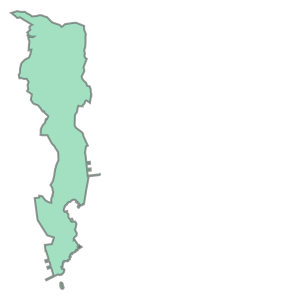

In [22]:
df['geometry'][26]

In [21]:
multipolygon(df['geometry'][26])

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [20]:
def multipolygon(data):
    long, lat  = data.exterior.xy
    d = [[x,y] for x,y in zip(long,lat)]
    return d

def short_form(data):
    if(' ' in data or len(data)>=5):
        return data[:data.find('시')+1]
    else:
        return data


df['geometry'] = df['geometry'].apply(multipolygon)

df = pd.DataFrame(df)
df['loc_kor'] = df['loc_kor'].apply(short_form)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [27]:
# 서울시 행정구역 코드 데이터 불러오기
# 출처: 공공데이터포털
sigun = pd.read_csv('./data/sigungu.csv')
sigun= sigun[['SIG_CD','SIDO_NM','SIG_KOR_NM']]
sigun.columns = ['code','city','loc_kor']
sigun['code'] = sigun['code'].apply(lambda x:str(x)[:5])
sigun = sigun.drop_duplicates()
sigun = sigun.dropna()

In [28]:
def short_form(data):
    if(' ' in data or len(data)>=5):
        return data[:data.find('시')+1]
    else:
        return data
    
sigun['loc_kor'] = sigun['loc_kor'].apply(short_form)
sigun.iloc[17,2]='세종특별자치시'

In [29]:
a=pd.merge(df,sigun,on=['code','loc_kor'])
aged_final = pd.merge(aged,a,on=['city','loc_kor'])

In [30]:
# 고령화 비율 정규화
x= np.array(aged_final['aged_per']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)
aged_final['normalized']=X_scaled

In [32]:
aged_final2= aged_final.copy()
# aged_final2['geometry'] = aged_final2['geometry'].apply(multipolygon)

In [52]:
# 전국 선별진료소 위치 표시 
layer_hos = pydeck.Layer(
    'ScatterplotLayer',
    hos,
    get_position='[lng, lat]',
    get_radius=1000,
    get_fill_color='[250, 100, 100]',
    pickable=True, 
    auto_highlight=True
)

layer_pop = pydeck.Layer('PolygonLayer',  
                  aged_final2,
                  get_polygon='geometry', 
                  get_fill_color='[0, 255*normalized, 0]',  
                  pickable=True,  
                  auto_highlight=True
                 ) 


center = [126.986, 37.565]
view_state = pydeck.ViewState(
    longitude=126.986,
    latitude=37.565,
    zoom=6)

r222 = pydeck.Deck(layers=[layer_hos], initial_view_state=view_state)

r222.to_html('hospital.html')

# pydeck 데이터를 데이콘 상에서 바로 표시할 수 없어서 캡쳐 화면으로 대신했습니다.
# 아래 지도 그래프에 대한 자세한 사항은 해당 링크를 클릭하시면 보실 수 있습니다!
# Image('hospital.png')

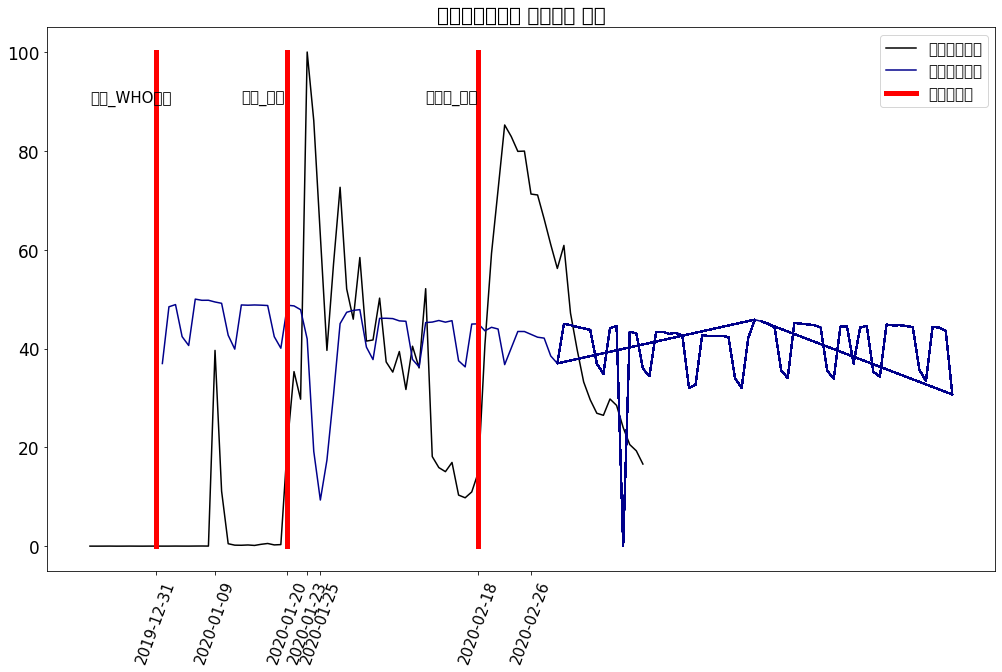

In [46]:
# 코로나 검색 데이터 및 서울 유동인구 데이터 불러오기
ST = pd.read_csv('./data/SearchTrend.csv')
SF = pd.read_csv('./data/SeoulFloating.csv')
SF = SF[SF['date']!='2020-02-23']

# 서울 유동인구 일별 평균 구한 후 정규화 실시
s=SF.groupby('date')['fp_num'].transform('mean')
x=np.array(s[1450:]).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)*50

plt.figure(figsize=(17,10))
plt.plot(ST['date'][1450:1535],ST['coronavirus'][1450:1535],lw=1.5,c='black')
plt.plot(SF['date'][1450:],X_scaled,lw=1.5,c='darkblue')
plt.plot([ST['date'][ST[ST['date']=='2020-01-20'].index[0]],ST['date'][ST[ST['date']=='2020-01-20'].index[0]]],[0,100],lw=5, c='r')
plt.plot([ST['date'][ST[ST['date']=='2019-12-31'].index[0]],ST['date'][ST[ST['date']=='2019-12-31'].index[0]]],[0,100],lw=5, c='r')
plt.plot([ST['date'][ST[ST['date']=='2020-02-18'].index[0]],ST['date'][ST[ST['date']=='2020-02-18'].index[0]]],[0,100],lw=5, c='r')
plt.annotate('국내_확진',[ST['date'][ST[ST['date']=='2020-01-20'].index[0]-7],90],fontsize=15)
plt.annotate('중국_WHO보고',[ST['date'][ST[ST['date']=='2019-12-31'].index[0]-10],90],fontsize=15)
plt.annotate('신천지_확진',[ST['date'][ST[ST['date']=='2020-02-18'].index[0]-8],90],fontsize=15)
plt.xticks(['2019-12-31','2020-01-09','2020-01-20','2020-01-23','2020-01-25','2020-02-18','2020-02-26'],rotation=70, fontsize=15)
plt.yticks(fontsize=17)
plt.legend(['코로나검색량','유동인구평균','사건기준일'],loc='upper right',fontsize=15)
plt.title('코로나검색량과 유동인구 추이',fontsize=20)
plt.show()

In [48]:
# 전국 행정구역별 geojson파일 불러오기
# 출처: 공공데이터포털
df = gpd.read_file('./data/sigungu/SIG.shp')
df = df[['SIG_CD','SIG_ENG_NM','SIG_KOR_NM','geometry']]
df.columns = ['code','loc_eng','loc_kor','geometry']

# 서울데이터만 가져오기
seoul = ['강남구','강동구','강북구','강서구','관악구','광진구','구로구','금천구','노원구',
 '도봉구','동대문구','동작구','마포구','서대문구','서초구','성동구','성북구','송파구',
 '양천구','영등포구','용산구','은평구','종로구','중구','중랑구']

seoul_data = pd.DataFrame(columns=['code','loc_eng','loc_kor','geometry'])

for s in range(len(seoul)):
    sl = df[df['loc_kor']==seoul[s]]
    seoul_data = pd.concat([seoul_data,sl])

def multipolygon(data):
    long, lat  = data.exterior.xy
    d = [[x,y] for x,y in zip(long,lat)]
    return d

seoul_data['geometry'] = seoul_data['geometry'].apply(multipolygon)
seoull = pd.DataFrame(seoul_data)

SF.columns = ['date','hour','birth_year','sex','province','loc_eng','fp_num']
dongj = list(SF['loc_eng'])
for d in range(len(dongj)):
    if(dongj[d]=='Dongjag-gu'):
        dongj[d]='Dongjak-gu'
        
SF['loc_eng'] = dongj

sf = SF[['date','loc_eng','fp_num']]
ss = sf.groupby(['date','loc_eng']).mean()

# 유동인구 정규화 
x=np.array(ss['fp_num']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)
ss['normalized']=X_scaled

seul = ss.reset_index()
soul = pd.merge(seul,seoull, on = 'loc_eng')

def changeint(date):
    d = date.split('-')
    return int(''.join(d))

soul['intdate'] = soul['date'].apply(changeint)

soul1 = soul[soul['intdate']==20200118]
# pydeck으로 표현
layer = pydeck.Layer('PolygonLayer',  
                  soul1,
                  get_polygon='geometry', 
                  get_fill_color='[0, 255*normalized, 0]',  
                  pickable=True,  
                  auto_highlight=True, 
                     extruded = True,
                     get_elevation = 'fp_num',
                     elevation_scale=0.05
                 ) 

center = [126.986, 37.565] 
view_state = pydeck.ViewState( longitude=center[0], latitude=center[1], zoom=10) 

view_state.bearing=15 
view_state.pitch=45

r3 = pydeck.Deck(layers=[layer], initial_view_state=view_state) 

#r3.to_html('seoulfloat0118.html')

soul2 = soul[soul['intdate']==20200125]
# pydeck으로 표현
layer = pydeck.Layer('PolygonLayer',  
                  soul2,
                  get_polygon='geometry', 
                  get_fill_color='[0, 255*normalized, 0]',  
                  pickable=True,  
                  auto_highlight=True, 
                     extruded = True,
                     get_elevation = 'fp_num',
                     elevation_scale=0.05
                 ) 

center = [126.986, 37.565] 
view_state = pydeck.ViewState( longitude=center[0], latitude=center[1], zoom=10) 

view_state.bearing=15 
view_state.pitch=45

r3 = pydeck.Deck(layers=[layer], initial_view_state=view_state) 


r3.to_html('seoulfloat0125.html')

# pydeck 데이터를 데이콘 상에서 바로 표시할 수 없어서 캡쳐 화면으로 대신했습니다.
# 아래 지도 그래프에 대한 자세한 사항은 해당 링크를 클릭하시면 보실 수 있습니다!
# 기존 ipywidgets을 활용하여 스크롤 이동을 통해 1월 전체와 2월 전체의 데이터를 확인하는 작업은 용량과 기능상의 문제로 
# 특정날짜만 보여주도록 설정했습니다.
